In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

# Save references to the tables
Station= Base.classes.station
Measurement= Base.classes.measurement


In [8]:
# View all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [9]:
# Save references to each table
Station= Base.classes.station
Measurement=Base.classes.measurement


In [10]:
# Create our session (link) from Python to the DB
session= Session(engine)


# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
recent_date= session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]

print(f"The msot recent date in the data set is: {recent_date}")

The msot recent date in the data set is: 2017-08-23


            date  precipitation
0     2016-08-23           0.00
1009  2016-08-23            NaN
1529  2016-08-23           1.79
704   2016-08-23           0.05
361   2016-08-23           0.15


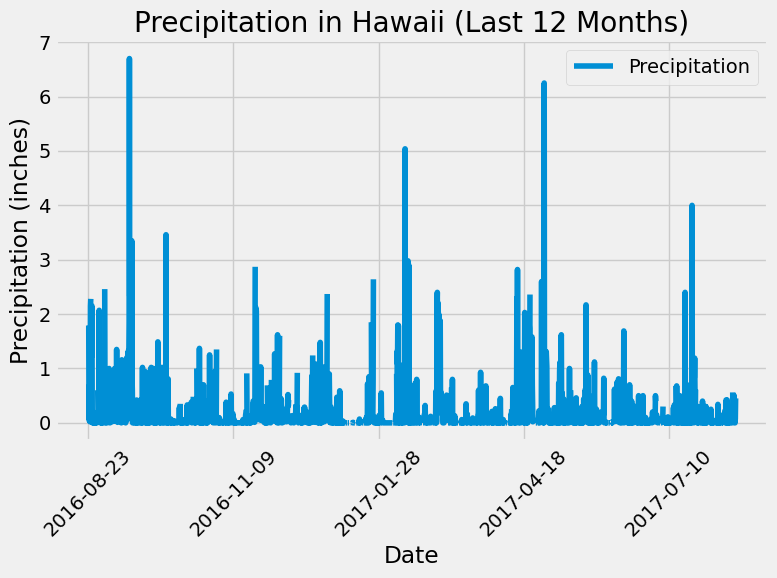

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.

import datetime as dt
from dateutil.relativedelta import relativedelta

# Calculate the date one year from the last date in the database.
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
last_date = dt.datetime.strptime(last_date, '%Y-%m-%d').date()
one_year_ago = last_date - relativedelta(years=1)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).\
          filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(results, columns=['date', 'precipitation'])

# Sort the dataframe by date
df = df.sort_values('date')

# View the first 5 rows of the sorted dataframe
print(df.head())

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(x='date', y='precipitation', figsize=(8,6))
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.title("Precipitation in Hawaii (Last 12 Months)")
plt.legend(["Precipitation"])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [14]:
import pandas as pd

# Query the precipitation data and save it as a Pandas DataFrame
results = session.query(Measurement.date, Measurement.prcp).all()
df = pd.DataFrame(results, columns=['date', 'precipitation'])

# Use the describe() function to calculate the summary statistics
print(df['precipitation'].describe())


count    18103.000000
mean         0.160644
std          0.468746
min          0.000000
25%          0.000000
50%          0.010000
75%          0.110000
max         11.530000
Name: precipitation, dtype: float64


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number of stations in the dataset
num_stations = session.query(func.count(Station.station)).scalar()
print(f'There are {num_stations} stations in the dataset.')


There are 9 stations in the dataset.


In [16]:
from sqlalchemy import desc

# Query to find the most active stations
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                    group_by(Measurement.station).\
                    order_by(desc(func.count(Measurement.station))).all()

# Print the results
for station, count in active_stations:
    print(f"Station ID: {station} has {count} rows")


Station ID: USC00519281 has 2772 rows
Station ID: USC00519397 has 2724 rows
Station ID: USC00513117 has 2709 rows
Station ID: USC00519523 has 2669 rows
Station ID: USC00516128 has 2612 rows
Station ID: USC00514830 has 2202 rows
Station ID: USC00511918 has 1979 rows
Station ID: USC00517948 has 1372 rows
Station ID: USC00518838 has 511 rows


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.


[(54.0, 85.0, 71.66378066378067)]

In [17]:
# Query to get the most active station
most_active_station = session.query(Measurement.station)\
                                 .group_by(Measurement.station)\
                                 .order_by(func.count().desc())\
                                 .first()[0]

# Query to get the lowest, highest, and average temperature for the most active station
temp_query = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))\
                   .filter(Measurement.station == most_active_station)\
                   .all()

# Print the results
print(f"Temperature observations for station {most_active_station}:")
print(f"Lowest temperature: {temp_query[0][0]} F")
print(f"Highest temperature: {temp_query[0][1]} F")
print(f"Average temperature: {temp_query[0][2]:.1f} F")


Temperature observations for station USC00519281:
Lowest temperature: 54.0 F
Highest temperature: 85.0 F
Average temperature: 71.7 F


# Close Session

In [18]:
# Close Session
session.close()